<h1 style="font-size:2.5em; color:#f5a442;">Machine Learning [4483] Project: A second
hand car price prediction
system with additional trends and
insights</h1>

<h2 style="font-size:1.5em; color:#808080;">Kai Broux (r0745431) and Luigi Guerriero (r0760424)</h2>
<h2 style="font-size:1.0em; color:#808080;">Master's students IIW UHasselt-KULeuven Campus Diepenbeek</h2>

# 1. Introduction

The goal of our project is to make a price prediction system for used cars and to extract interesting information and insights. The price prediction model and insights can be extracted from a dataset of different used cars. The model and insights could be then later used as a tool for a second-hand car retailer to give insights to potential customers shopping for a second-hand car. Moreover, this price prediction model and insights tool may also come in handy for a customer looking to sell his/her car.

This [`dataset`](https://www.kaggle.com/adityadesai13/used-car-dataset-ford-and-mercedes) contains data from 100 000 used cars from the UK which are divided into separate brands. Each brand is divided into a separate file and contains information about the model, year, price, transmission, mileage, fuel type, road tax, mpg and engine size.

Before we begin with the project, we need to import all libraries required for this project. Throughout the course, we will be using [`numpy`](http://www.numpy.org/) for all arrays and matrix operations, and [`matplotlib`](https://matplotlib.org/) for plotting. In this assignment, we will also use [`scipy`](https://docs.scipy.org/doc/scipy/reference/), which contains scientific and numerical computation functions and tools. 

In [149]:
# used for manipulating directory paths
import os

# Scientific and vector computation for python
import numpy as np

# used for importing .csv data
import pandas as pd

# Plotting library
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D  # needed to plot 3-D surfaces

# Optimization module in scipy
from scipy import optimize


# tells matplotlib to embed plots within the notebook
%matplotlib inline

# 2. Project itself

###  2.1 Loading in the data

As mentioned in the introduction a separate file of a car brand is stored in a `.csv` file and consist of the following columns:

    Model: Model type.
    Year: Registration Year.
    Price: Price in euros.
    Transmission: Type of Gearbos.
    Mileage: Distance Used.
    FuelType: Engine Fuel.
    Tax: Road Tax.
    mpg: Miles per Gallon.
    EngineSize: Size in litres.
    Brand: Name of the car brand.

Because the dataset also includes an abundance of information of a specefic car model, we will leave them outside of the dataset and only consider a brand with different models. Therefore we will leave out the `cclass.csv` and `focus.csv` files.

To load in the dataset, we first have to load in the separate `.csv` files. 

In [2]:
audi = pd.read_csv("dataset/audi.csv")
bmw = pd.read_csv("dataset/bmw.csv")
ford = pd.read_csv("dataset/ford.csv")
hyundai = pd.read_csv("dataset/hyundi.csv")
mercedes = pd.read_csv("dataset/merc.csv")
skoda = pd.read_csv("dataset/skoda.csv")
toyota = pd.read_csv("dataset/toyota.csv")
vauxhall = pd.read_csv("dataset/vauxhall.csv")
volkswagen = pd.read_csv("dataset/vw.csv")

We are having different datasets for different brands. So if we want to combine them we need to add an extra column to each `.csv` file describing the name of the brand :

In [3]:
audi['brand'] = 'audi'
bmw['brand'] = 'bmw'
ford['brand'] = 'ford'
hyundai['brand'] = 'hyundai'
mercedes['brand'] = 'mercedes'
skoda['brand'] = 'skoda'
toyota['brand'] = 'toyota'
vauxhall['brand'] = 'vauxhall'
volkswagen['brand'] = 'volkswagen'

df = pd.concat([audi,bmw,
               ford,hyundai,mercedes,skoda,toyota,
               vauxhall,volkswagen])
# drop the tax column
df.drop('tax(£)',axis=1,inplace=True)
df

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,brand
0,A1,2017,12500,Manual,15735,Petrol,150.0,55.4,1.4,audi
1,A6,2016,16500,Automatic,36203,Diesel,20.0,64.2,2.0,audi
2,A1,2016,11000,Manual,29946,Petrol,30.0,55.4,1.4,audi
3,A4,2017,16800,Automatic,25952,Diesel,145.0,67.3,2.0,audi
4,A3,2019,17300,Manual,1998,Petrol,145.0,49.6,1.0,audi
...,...,...,...,...,...,...,...,...,...,...
15152,Eos,2012,5990,Manual,74000,Diesel,125.0,58.9,2.0,volkswagen
15153,Fox,2008,1799,Manual,88102,Petrol,145.0,46.3,1.2,volkswagen
15154,Fox,2009,1590,Manual,70000,Petrol,200.0,42.0,1.4,volkswagen
15155,Fox,2006,1250,Manual,82704,Petrol,150.0,46.3,1.2,volkswagen


### 2.2 Lineair regression with one variable 

To start of simply, we are going to apply linear regression with one variable to determine the price of a Mercedes C-class, more specefic the W205 model. We can use the `cclass.csv` and only look to at the the C-class from years 2014-2021.

We have to first load the dataset:

In [4]:
cclass = pd.read_csv("dataset/cclass.csv")
display(cclass)

,model,year,price,transmission,mileage,fuelType,engineSize
0,C Class,2020,30495,Automatic,1200,Diesel,2.0
1,C Class,2020,29989,Automatic,1000,Petrol,1.5
2,C Class,2020,37899,Automatic,500,Diesel,2.0
3,C Class,2019,30399,Automatic,5000,Diesel,2.0
4,C Class,2019,29899,Automatic,4500,Diesel,2.0
...,...,...,...,...,...,...,...
3894,C Class,2017,14700,Manual,31357,Diesel,1.6
3895,C Class,2018,18500,Automatic,28248,Diesel,2.1
3896,C Class,2014,11900,Manual,48055,Diesel,2.1
3897,C Class,2014,11300,Automatic,49865,Diesel,2.1


Since we want to examine the C-class W205 model we have to filter out the C-classes that are not in the 2014-2021 year-range: 

In [5]:
cclass = cclass[(cclass['year'] > 2013) & (cclass['year'] < 2022)]
display(cclass)

,model,year,price,transmission,mileage,fuelType,engineSize
0,C Class,2020,30495,Automatic,1200,Diesel,2.0
1,C Class,2020,29989,Automatic,1000,Petrol,1.5
2,C Class,2020,37899,Automatic,500,Diesel,2.0
3,C Class,2019,30399,Automatic,5000,Diesel,2.0
4,C Class,2019,29899,Automatic,4500,Diesel,2.0
...,...,...,...,...,...,...,...
3894,C Class,2017,14700,Manual,31357,Diesel,1.6
3895,C Class,2018,18500,Automatic,28248,Diesel,2.1
3896,C Class,2014,11900,Manual,48055,Diesel,2.1
3897,C Class,2014,11300,Automatic,49865,Diesel,2.1


For the lineair regression with one variable, we will choose the mileage as variable (for the x-axis). The price will be selected for the y-axis. We will then visualise the data. Following function can help us to quickly plot graphs:

In [13]:
def plotData(x, y):
    fig = pyplot.figure()  # open a new figure    
    pyplot.plot(x, y, 'ro', ms=10, mec='k')
    pyplot.ylabel('Price of a W205 C-Class in £')
    pyplot.xlabel('Mileage in miles')   

[ 1200  1000   500 ... 48055 49865 55445]


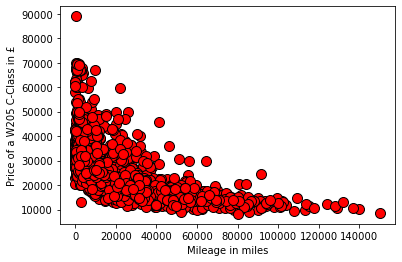

In [165]:
#X and y values
X = cclass['mileage'].to_numpy()
y = cclass['price'].to_numpy()
m = y.size #dataset size
print(X)

#Visualise data
plotData(X,y)

#### Gradient descent  

In this part, you will fit the linear regression parameters $\theta$ to our dataset using gradient descent.

The objective of linear regression is to minimize the cost function

$$ J(\theta) = \frac{1}{2m} \sum_{i=1}^m \left( h_{\theta}(x^{(i)}) - y^{(i)}\right)^2$$

where the hypothesis $h_\theta(x)$ is given by the linear model
$$ h_\theta(x) = \theta^Tx = \theta_0 + \theta_1 x_1$$

Recall that the parameters of your model are the $\theta_j$ values. These are
the values you will adjust to minimize cost $J(\theta)$. One way to do this is to
use the batch gradient descent algorithm. In batch gradient descent, each
iteration performs the update

$$ \theta_j = \theta_j - \alpha \frac{1}{m} \sum_{i=1}^m \left( h_\theta(x^{(i)}) - y^{(i)}\right)x_j^{(i)} \qquad \text{simultaneously update } \theta_j \text{ for all } j$$

With each step of gradient descent, your parameters $\theta_j$ come closer to the optimal values that will achieve the lowest cost J($\theta$).

We first want to normalize our features to make sure our gradient descent works out without any overflow problems. Besides we add a column of ones to X:

In [166]:
mu = np.mean(X, axis = 0)
sigma = np.std(X, axis = 0)
X_norm = (X - mu) / sigma
print(X_norm)

[-0.9757839  -0.98598056 -1.01147222 ...  1.41303964  1.50531945
  1.78980638]


In [167]:
# Add a column of ones to X. The numpy function stack joins arrays along a given axis. 
# The first axis (axis=0) refers to rows (training examples) 
# and second axis (axis=1) refers to columns (features).


X_not_norm = X  #save original X if we need it later
X_not_norm_stacked = np.stack([np.ones(m), X_not_norm], axis=1)  #column of ones to X
X  = np.stack([np.ones(m), X_norm], axis=1)                      #column of ones to the normalized X
print("A column of ones to X-normalized:\n", X)
print("\nA column of ones to not normalized X:\n",X_not_norm_stacked)


A column of ones to X-normalized:
 [[ 1.         -0.9757839 ]
 [ 1.         -0.98598056]
 [ 1.         -1.01147222]
 ...
 [ 1.          1.41303964]
 [ 1.          1.50531945]
 [ 1.          1.78980638]]

A column of ones to not normalized X:
 [[1.0000e+00 1.2000e+03]
 [1.0000e+00 1.0000e+03]
 [1.0000e+00 5.0000e+02]
 ...
 [1.0000e+00 4.8055e+04]
 [1.0000e+00 4.9865e+04]
 [1.0000e+00 5.5445e+04]]


For the cost function we can define a function that determines the cost:

In [168]:
def computeCost(X, y, theta):
     
    # initialize some useful values
    m = y.size  # number of training examples
    
    # You need to return the following variables correctly
    J = 0
    
    h= np.dot(X,theta)
    inner = (h-y)**2
    J = (1/(2*m)) * (np.sum(inner))

    return J

For Gradient descent we can define following function:

In [169]:
def gradientDescent(X, y, theta, alpha, num_iters):
    # Initialize some useful values
    m = y.shape[0]  # number of training examples
    
    # make a copy of theta, to avoid changing the original array, since numpy arrays
    # are passed by reference to functions
    theta = theta.copy()
    
    J_history = [] # Use a python list to save cost in every iteration
    
    for i in range(num_iters):
        # ==================== YOUR CODE HERE =================================
        theta = theta - (alpha / m) * (np.dot(X, theta) - y).dot(X)

        # =====================================================================
        
        # save the cost J in every iteration
        J_history.append(computeCost(X, y, theta))
    
    return theta, J_history



We initialize the 𝜃 parameters to 0 and the learning rate 𝛼 to 0.01 and use the final parameters to plot the lineair fit:

In [170]:
# initialize fitting parameters
theta = np.zeros(2)

# some gradient descent settings
iterations = 100000
alpha = 0.0001

theta, J_history = gradientDescent(X ,y, theta, alpha, iterations)
print('Theta found by gradient descent: {:.4f}, {:.4f}'.format(*theta))

Theta found by gradient descent: 24299.4954, -5498.5852


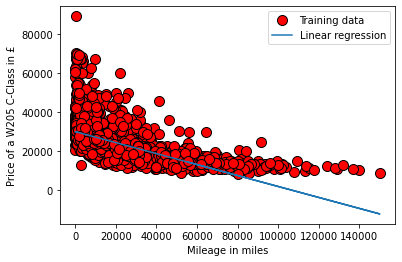

In [171]:
# plot the linear fit
plotData(X_not_norm_stacked[:, 1], y)
pyplot.plot(X_not_norm_stacked[:, 1], np.dot(X, theta), '-')
pyplot.legend(['Training data', 'Linear regression']);

## Regularised linear regression

In [172]:
def linearRegCostFunction(X, y, theta, lambda_=0.0):
    
    # Initialize some useful values
    m = y.size # number of training examples
    # You need to return the following variables correctly 
    J = 0
    grad = np.zeros(theta.shape)

    # ====================== YOUR CODE HERE ======================
    
    h= np.dot(X,theta)   
    J = (1/(2*m)) * (np.sum((h-y)**2)) + (lambda_/(2*m))*(np.sum(theta[1:]**2))   
    grad = (1 / m) * (h - y).dot(X)
    grad[1:] = grad[1:] + (lambda_ / m) * theta[1:]

    # ============================================================
    return J, grad

def trainLinearReg(linearRegCostFunction, X, y, lambda_=0.0, maxiter=200):
    """
    Trains linear regression using scipy's optimize.minimize.

    Parameters
    ----------
    X : array_like
        The dataset with shape (m x n+1). The bias term is assumed to be concatenated.

    y : array_like
        Function values at each datapoint. A vector of shape (m,).

    lambda_ : float, optional
        The regularization parameter.

    maxiter : int, optional
        Maximum number of iteration for the optimization algorithm.

    Returns
    -------
    theta : array_like
        The parameters for linear regression. This is a vector of shape (n+1,).
    """
    # Initialize Theta
    initial_theta = np.zeros(X.shape[1])

    # Create "short hand" for the cost function to be minimized
    costFunction = lambda t: linearRegCostFunction(X, y, t, lambda_)

    # Now, costFunction is a function that takes in only one argument
    options = {'maxiter': maxiter}

    # Minimize using scipy
    res = optimize.minimize(costFunction, initial_theta, jac=True, method='TNC', options=options)
    return res.x

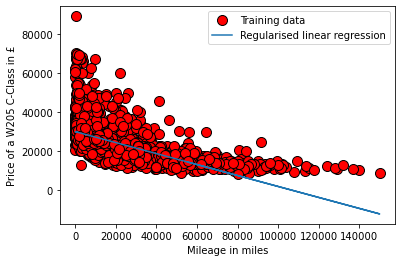

In [227]:
theta_regularized = trainLinearReg(linearRegCostFunction, X, y, lambda_=0)
# plot the linear fit
plotData(X_not_norm_stacked[:, 1], y)
pyplot.plot(X_not_norm_stacked[:, 1], np.dot(X, theta_regularized), '-')
pyplot.legend(['Training data', 'Regularised linear regression']);

## Regularised linear regression

In [268]:
def polyFeatures(X, p):
    """
    Maps X (1D vector) into the p-th power.
    
    Parameters
    ----------
    X : array_like
        A data vector of size m, where m is the number of examples.
    
    p : int
        The polynomial power to map the features. 
    
    Returns 
    -------
    X_poly : array_like
        A matrix of shape (m x p) where p is the polynomial 
        power and m is the number of examples. That is:
    
        X_poly[i, :] = [X[i], X[i]**2, X[i]**3 ...  X[i]**p]
    
    Instructions
    ------------
    Given a vector X, return a matrix X_poly where the p-th column of
    X contains the values of X to the p-th power.
    """
    # You need to return the following variables correctly.
    X_poly = np.zeros((X.shape[0], p))

    # ====================== YOUR CODE HERE ======================

    for i in range(p):
        X_poly[:, i] = X[:, 0] ** (i + 1)

    # ============================================================
    return X_poly

def plotFit(polyFeatures, min_x, max_x, mu, sigma, theta, p):
    """
    Plots a learned polynomial regression fit over an existing figure.
    Also works with linear regression.
    Plots the learned polynomial fit with power p and feature normalization (mu, sigma).

    Parameters
    ----------
    polyFeatures : func
        A function which generators polynomial features from a single feature.

    min_x : float
        The minimum value for the feature.

    max_x : float
        The maximum value for the feature.

    mu : float
        The mean feature value over the training dataset.

    sigma : float
        The feature standard deviation of the training dataset.

    theta : array_like
        The parameters for the trained polynomial linear regression.

    p : int
        The polynomial order.
    """
    # We plot a range slightly bigger than the min and max values to get
    # an idea of how the fit will vary outside the range of the data points
    x = np.arange(min_x - 15, max_x + 25, 0.05).reshape(-1, 1)

    # Map the X values
    X_poly = polyFeatures(x, p)
    X_poly -= mu
    X_poly /= sigma

    # Add ones
    X_poly = np.concatenate([np.ones((x.shape[0], 1)), X_poly], axis=1)

    # Plot
    pyplot.plot(x, np.dot(X_poly, theta), '--', lw=2)
    
    
def hypothesis(X, theta):
    y1 = theta*X
    return np.sum(y1, axis=1)

[[ 1.20000000e+03  1.44000000e+06  1.72800000e+09  2.07360000e+12]
 [ 1.00000000e+03  1.00000000e+06  1.00000000e+09  1.00000000e+12]
 [ 5.00000000e+02  2.50000000e+05  1.25000000e+08  6.25000000e+10]
 ...
 [ 4.80550000e+04  2.30928302e+09  1.10972596e+14  5.33278809e+18]
 [ 4.98650000e+04  2.48651822e+09  1.23990231e+14  6.18277288e+18]
 [ 5.54450000e+04  3.07414802e+09  1.70446137e+14 -8.99635799e+18]]
[[-0.9757839  -0.49440389 -0.28025069 -0.2744902 ]
 [-0.98598056 -0.49467685 -0.28025524 -0.27449074]
 [-1.01147222 -0.49514212 -0.2802607  -0.2744912 ]
 ...
 [ 1.41303964  0.93728531  0.41259195  2.38021808]
 [ 1.50531945  1.04723461  0.49386709  2.80334807]
 [ 1.78980638  1.41177554  0.78391288 -4.75295822]]
[[ 1.         -0.9757839  -0.49440389 -0.28025069 -0.2744902 ]
 [ 1.         -0.98598056 -0.49467685 -0.28025524 -0.27449074]
 [ 1.         -1.01147222 -0.49514212 -0.2802607  -0.2744912 ]
 ...
 [ 1.          1.41303964  0.93728531  0.41259195  2.38021808]
 [ 1.          1.505319

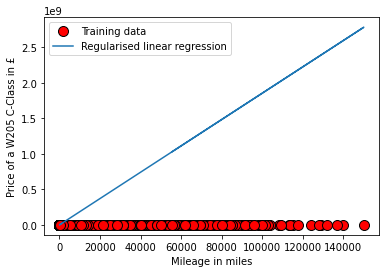

In [273]:
p = 4
X_not_norm_poly = np.array(X_not_norm).reshape(np.array(X_not_norm).size,1)
# Map X onto Polynomial Features 
X_not_norm_poly = polyFeatures(X_not_norm_poly, p)
print(X_not_norm_poly)


# normalize features
mu = np.mean(X_not_norm_poly, axis = 0)
sigma = np.std(X_not_norm_poly, axis = 0)
X_poly_norm = (X_not_norm_poly - mu) / sigma
print(X_poly_norm)
X_poly_norm_with_ones = np.concatenate([np.ones((m, 1)), X_poly_norm], axis=1)
print(X_poly_norm_with_ones)


lambda_ = 0
theta_poly = trainLinearReg(linearRegCostFunction, X_poly_norm_with_ones, y,
                             lambda_=lambda_, maxiter=55)
theta_poly = theta_poly.reshape(1,-1)
print(theta_poly.shape)
print(theta_poly)
h = hypothesis(X_not_norm_stacked[:,1].reshape(-1,1),theta_poly)
print(h)

plotData(X_not_norm_stacked[:, 1], y)
pyplot.plot(X_not_norm_stacked[:, 1], h, '-')
pyplot.legend(['Training data', 'Regularised linear regression']);
#print(hypothesis(X_not_norm_stacked[:,1], theta_poly))
